# Multimodal Agent Chat for Content Generation: DALL-E 3 and GPT-4o

<img src="media/autogen-interior-design.png" alt="Image description" width="700">

This notebook uses the following agents:

1. __User proxy__: Represents the human user who provides an initial text prompt for image generation
2. __Image creator__: DALL-E 3 image generation based on the provided text prompt
3. __Critic__: Provides detailled critic about the generated image and a revised text prompt in order to improve the image

## Setup
Install pyautogen with llm option:
```bash
pip install "pyautogen[lmm]>=0.2.3"
```

In [1]:
import os
from typing import Any, Dict, List, Optional, Union
from dotenv import load_dotenv, find_dotenv

from openai import AzureOpenAI

from autogen import Agent, AssistantAgent, ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.img_utils import _to_pil
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent

from dalle_utils import dalle_call, extract_img, extract_prompt_content, display_image

In [2]:
load_dotenv(find_dotenv())
aoai_endpoint = os.getenv("AZURE_OAI_ENDPOINT")
aoai_key = os.getenv("AZURE_OAI_KEY")

config_list_gpt4 = [
    {'model' : 'gpt-4o-global', # Your GPT4o deployment name 
     'azure_endpoint' : aoai_endpoint,
     'api_key': aoai_key,
     'api_type' : 'azure',
     'api_version' : '2024-05-01-preview'}
]

config_list_dalle = [
    {'model' : 'dalle', # Your DALL-E 3 deployment name 
     'azure_endpoint' : aoai_endpoint,
     'api_key': aoai_key,
     'api_type' : 'azure',
     'api_version' : '2024-05-01-preview'}
]

gpt4_llm_config = {"config_list": config_list_gpt4, "cache_seed": None}

## The DALL-E 3 Agent
Define an agent that creates an image based on a text prompt using the DALL-E 3 API. We are using the AutoGen ConversableAgent as base class.

In [3]:
class DALLEAgent(ConversableAgent):
    def __init__(self, name, llm_config: dict, **kwargs):
        super().__init__(name, llm_config=llm_config, **kwargs)
        
        try:
            config_list = llm_config["config_list"]
            api_key = config_list[0]["api_key"]
            api_version = config_list[0]["api_version"]
            azure_endpoint = config_list[0]["azure_endpoint"]
        except Exception as e:
            print("Unable to fetch API Key, because", e)
            api_key = os.getenv("OPENAI_API_KEY")

        self._dalle_client = AzureOpenAI(api_version=api_version, api_key=api_key, azure_endpoint=azure_endpoint)
        self.register_reply([Agent, None], DALLEAgent.generate_dalle_reply)

    def send(self, message: Union[Dict, str], recipient: Agent, request_reply: Optional[bool] = None, silent: Optional[bool] = False):
        # override and always "silent" the send out message to avoid long printed outputs
        super().send(message, recipient, request_reply, silent=True)

    def generate_dalle_reply(self, messages: Optional[List[Dict]], sender: "Agent", config):
        """Generate a reply using OpenAI DALLE call."""
        client = self._dalle_client if config is None else config
        if client is None:
            return False, None
        if messages is None:
            messages = self._oai_messages[sender]

        prompt = messages[-1]["content"]
        img_data = dalle_call(
            client=client,
            model="dall-e-3",
            prompt=prompt,
            size="1792x1024",
            quality="hd",
            n=1,
        )

        img_data = _to_pil(img_data)

        # Return the OpenAI message format
        return True, {"content": [{"type": "image_url", "image_url": {"url": img_data}}]}

## Test the DALLE-E 3 Agent by a call from the User Proxy

User_proxy (to Dalle):

Woman face with centered explosion of colorful powder on a black background.

--------------------------------------------------------------------------------


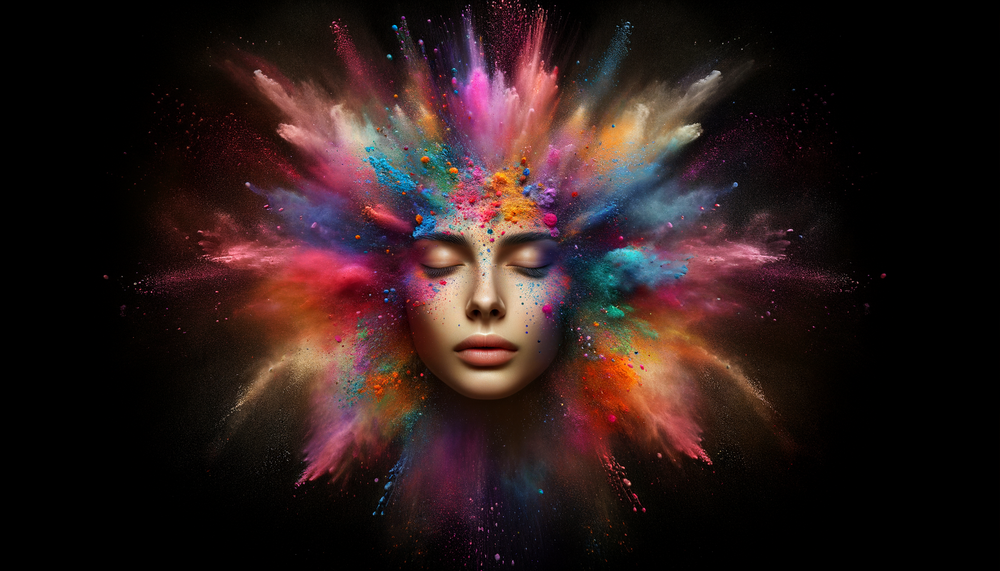

In [5]:
dalle = DALLEAgent(name="Dalle", llm_config={"config_list": config_list_dalle})

user_proxy = UserProxyAgent(
    name="User_proxy", system_message="A human admin.", human_input_mode="NEVER", max_consecutive_auto_reply=0
)

user_proxy.initiate_chat(
    dalle,
    message="Woman face with centered explosion of colorful powder on a black background.",
)

img = extract_img(dalle)
display_image(img, width=1000)

## Iterate several times with Critics
The DalleCreator performs a converation in order to iteratively improve the image. This dialog involves two roles:
1. Critics agent
- Reads the prompt and reviews the resulting image
- Provides feedback based on given critera: aesthetics, adherence to the prompt, correct representation of text, etc.
- Suggests a new prompt to improve the result
2. An instance of the DALL-E 3 agent
- Creates images based on an initial user prompt and revised prompts from the Critics agent

In [8]:
class DalleCreator(AssistantAgent):
    def __init__(self, n_iters=2, **kwargs):
        """
        Initializes a DalleCreator instance.

        This agent facilitates the creation of visualizations through a collaborative effort among
        its child agents: dalle and critics.

        Parameters:
            - n_iters (int, optional): The number of "improvement" iterations to run. Defaults to 2.
            - **kwargs: keyword arguments for the parent AssistantAgent.
        """
        super().__init__(**kwargs)
        self.register_reply([Agent, None], reply_func=DalleCreator._reply_user, position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        img_prompt = messages[-1]["content"]

        # Define the agents
        self.critics = MultimodalConversableAgent(
            name="Critics",
            system_message="""You are an image generation prompt engineering expert who improves the prompt of the image you saw to generate a new image using the DALL-E 3 image generation model.
            Consider the following:
            - How to create an image that better matches the prompt
            - Improve the image in terms of composition, color, shape, quality etc.
            - If the initial prompt asks for a text to be displayed, check if represented in the image without mistakes.
            - DALL-E 3 might not understand negations. If you want an object not to be shown, it is better to not mention it at all. 
            Keep in mind that the image generation model might not be able to consider all details. Focus on the most important aspects in the revised prompt.
            

            Reply in  the following format:
            CRITICS: 
            <numbered list of critics>
            PROMPT:
            <your revised text prompt as input for the DALL-E 3 image generation model>
            """,
            llm_config={"config_list": config_list_gpt4, "max_tokens": 1000},
            human_input_mode="NEVER",
            max_consecutive_auto_reply=3,
        )

        self.dalle = DALLEAgent(
            name="Dalle", llm_config={"config_list": config_list_dalle}, max_consecutive_auto_reply=0
        )

        # Data flow begins
        self.send(message=img_prompt, recipient=self.dalle, request_reply=True)
        img = extract_img(self.dalle)

        display_image(img)
        print("Image PLOTTED")

        for i in range(self._n_iters):
            img = extract_img(self.dalle)
            img.save("result.png")

            self.msg_to_critics = f"""Here is the prompt: {img_prompt}.
            Here is the image <img result.png>.
            Now, provide your critic and create a prompt optimized for the DALL-E 3 image generation model so it can generate a better image.
            Show both "CRITICS" and "PROMPT".
            """
            self.send(message=self.msg_to_critics, recipient=self.critics, request_reply=True)
            feedback = self._oai_messages[self.critics][-1]["content"]
            
            img_prompt = extract_prompt_content(feedback)

            self.send(message=img_prompt, recipient=self.dalle, request_reply=True)
            img = extract_img(self.dalle)
            display_image(img)
            print(f"Image {i} PLOTTED")

        return True, "result.jpg"

User (to DALL-E 3 Creator):

Modern living room with lake view

--------------------------------------------------------------------------------


DALL-E 3 Creator (to Dalle):

Modern living room with lake view

--------------------------------------------------------------------------------


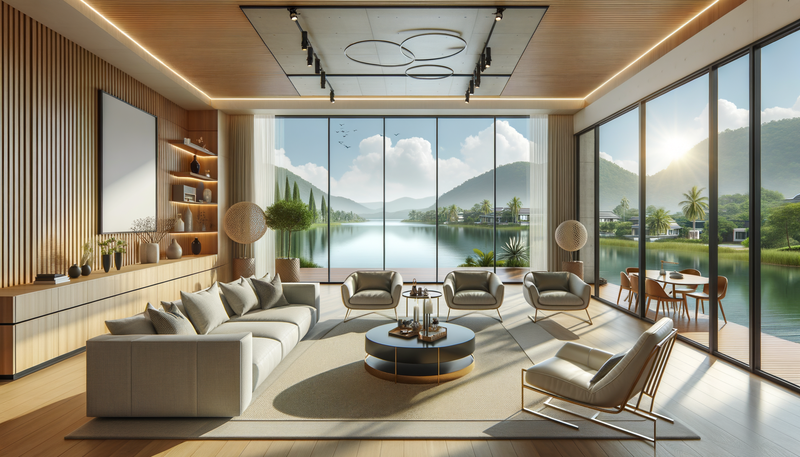

Image PLOTTED
DALL-E 3 Creator (to Critics):

Here is the prompt: Modern living room with lake view.
            Here is the image <image>.
            Now, provide your critic and create a prompt optimized for DALL-E 3 so that DALLE can generate better image.
            Show both "CRITICS" and "PROMPT".
            

--------------------------------------------------------------------------------
Critics (to DALL-E 3 Creator):

CRITICS:
1. The image already captures a great modern living room with a beautiful lake view, but there are always small improvements that can be made.
2. The color scheme is cohesive and modern, but it might benefit from a slight pop of color for more visual interest.
3. The space could potentially incorporate more personal touches or contemporary art pieces to enhance the overall modern feel.
4. The view is stunning, but adding a small boat or people by the lake could make it more dynamic and lively.
5. The furnishings and layout are excellent, yet the addit

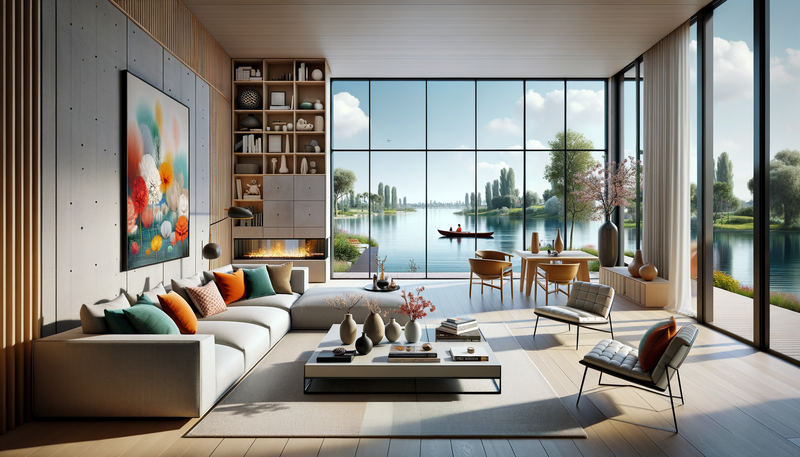

Image 0 PLOTTED
DALL-E 3 Creator (to Critics):

Here is the prompt: A modern living room with a stunning lake view through floor-to-ceiling windows. The room features a neutral color palette with a pop of vibrant color through accent pillows and artwork. Contemporary furniture includes a sophisticated sectional sofa, designer chairs, and a sleek coffee table. Add personal touches such as stylish vases, modern art pieces, and books on built-in shelves. The view outside shows a serene lake with a small boat and a few people by the shore, capturing a lively and dynamic scene. Optionally, include a modern fireplace to enhance the cozy atmosphere of the space..
            Here is the image <image>.
            Now, provide your critic and create a prompt optimized for DALL-E 3 so that DALLE can generate better image.
            Show both "CRITICS" and "PROMPT".
            

--------------------------------------------------------------------------------
Critics (to DALL-E 3 Creator):

CR

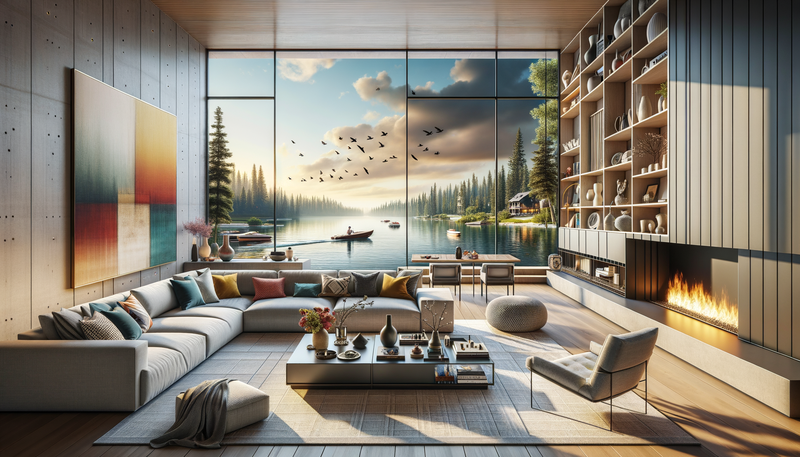

Image 1 PLOTTED
DALL-E 3 Creator (to User):

result.jpg

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'Modern living room with lake view', 'role': 'assistant'}, {'content': 'result.jpg', 'role': 'user'}], summary='result.jpg', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

In [ ]:
creator = DalleCreator(
    name="DALL-E 3 Creator",
    max_consecutive_auto_reply=0,
    system_message="Help me to coordinate generating an image",
    llm_config=gpt4_llm_config,
)

user_proxy = UserProxyAgent(name="User", human_input_mode="NEVER", max_consecutive_auto_reply=0)

user_proxy.initiate_chat(
    creator, message="""Modern living room with lake view"""
)